# Лабораторная работы №2
## Спектральный анализ биомедицинских сигналов.
***

### 1. Подключение библиотек.

In [2]:
import numpy as np
import laba1
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

### 2. Получение реальной ЭКГ.

In [3]:
from scipy.misc import electrocardiogram
ECG = electrocardiogram()

### 3. Создание объектов необходимых сигналов.

In [4]:
from abc import ABC, abstractmethod


class Signal:
    def __init__(self, *args, system = "orthogonal"):
        self.system = system
        self.x1 = 0
        self.y1 = 0
        self.re = 0
        self.im = 0
        self.mag = 0
        self.ph = 0
        if system == "polar":
            self.mag = args[0]
            self.ph = args[1]
        if system == "orthogonal":
            self.x1 = np.arange(args[0].size)
            self.y1 = args[0]
        if system == "orthogonal_frequency":
            self.re = args[0]
            self.im = args[1]

        
    def print_(self, title='Signal'):
        if self.system == "polar":
            fig, ax = plt.subplots(figsize=(8, 5),nrows=2, ncols=1)
            samples = np.linspace(0, 0.5, self.mag.size)
            ax[0].plot(samples, self.mag)
#             ax[0].scatter(samples, self.mag)
            ax[1].plot(samples, self.ph)

            ax[0].set_title(title, size=20)
            ax[0].set_xlabel('Samples')
            ax[1].set_xlabel('Samples')
            ax[0].set_ylabel('Amplitude')
            ax[1].set_ylabel('Amplitude')
            fig.tight_layout()
        
            
        if self.system == "orthogonal":
            
            fig, ax = plt.subplots(figsize=(8, 5))

            ax.plot(self.x1, self.y1)

            ax.set_title(title, size=20)
            ax.set_xlabel('Samples')
            ax.set_ylabel('Amplitude')
        
        plt.show()

            
class DFT(ABC):
    def __init__(self, signal):
        self.signal = signal
            
            
class DirectDFT(DFT):
    def correlation(self):
        samples = self.signal.x1.size
        ReX = np.zeros(samples//2 + 1)
        ImX = np.zeros(samples//2 + 1)
        X = self.signal.y1
        for k in np.arange(samples//2 + 1):
            for i in np.arange(samples):
                ReX[k] += X[i]*np.cos(2*np.pi*k*i/samples)
                ImX[k] += X[i]*np.sin(2*np.pi*k*i/samples)
        return Signal(ReX, ImX, system="orthogonal_frequency")
    
    def fft(self):
        pass
    

class InverseDFT(DFT):
    def inverse(self):
        ReX = self.signal.re
        ImX = self.signal.im
        samples = (self.signal.re.size - 1) * 2
        X = np.zeros(samples)
        for k in np.arange(samples//2 + 1):
            ReX[k] = ReX[k] / (samples/2)
            ImX[k] = (- ImX[k]) / (samples/2)
            
        ReX[0] = ReX[0] / 2
        ReX[-1] = ReX[-1] / 2
        
        for k in np.arange(samples//2 + 1):
            for i in np.arange(samples):
                X[samples - 1 - i] += ReX[k]*np.cos(2*np.pi*k*i/samples) + ImX[k]*np.sin(2*np.pi*k*i/samples)
                
        return Signal(X)


class CoordinateSystem(DFT):
    def to_polar(self):
        ReX = self.signal.re
        ImX = self.signal.im
        samples = ReX.size
        Mag = np.zeros(samples)
        Phase = np.zeros(samples)
        for k in np.arange(samples):
            Mag[k] += (ReX[k]**2 + ImX[k]**2)**0.5
            if ReX[k] == 0:
                Phase[k] += np.arctan(np.inf)
            else:
                Phase[k] += np.arctan(ImX[k]/ReX[k])
            if ReX[k] < 0 and ImX[k] < 0:
                Phase[k] -= np.pi
            if ReX[k] < 0 and ImX[k] >= 0:
                Phase[k] += np.pi
        return Signal(Mag, Phase, system="polar")

    
def research(signal):
    signal_spectrum = DirectDFT(signal).correlation()
    signal_polar = CoordinateSystem(signal_spectrum).to_polar()
    signal.print_()
    signal_polar.print_()
    

def sinc_func(f_c, m):
    h = np.zeros(m)
    for i in np.arange(m):
        if i == m/2:
            h[i] = 2*np.pi*f_c
        else:
            h[i] = (np.sin(2*np.pi*f_c*(i - m/2))/(i - m/2))*\
            (0.54 - 0.46*np.cos(2*np.pi*i/m))
            
    SUM = 0       
    for i in np.arange(m):
        SUM += h[i]
    for i in np.arange(m):
        h[i] /= SUM
        
    return Signal(h)


### 4. Получение спектров сигналов (ECG, White noise, Harm noise)

#### Прямое ДПФ кардиосигнала

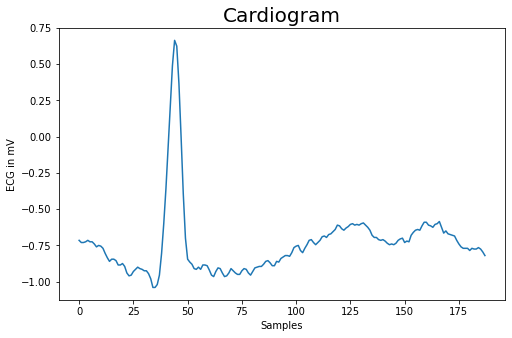

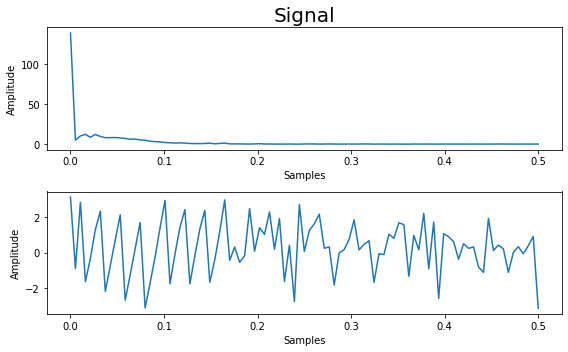

In [5]:
ecg = laba1.Ecg(1)
# zero = np.zeros(1000)
# ecg = Signal(np.append(ecg.y1, zero))
research(ecg)

#### Обратное ДПФ кардиосигнала

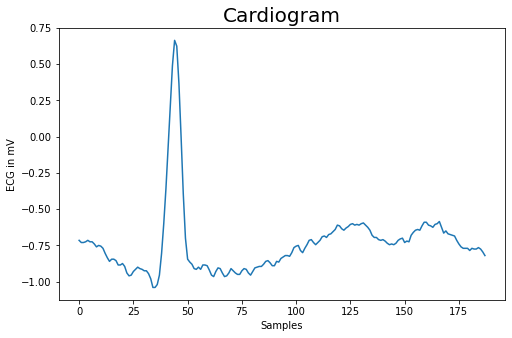

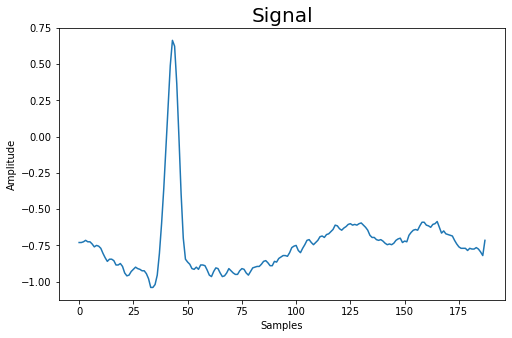

In [6]:
ecg_spectrum = DirectDFT(ecg).correlation()
inverse = InverseDFT(ecg_spectrum).inverse()
ecg.print_()
inverse.print_()

#### Прямое ДПФ Белого шума

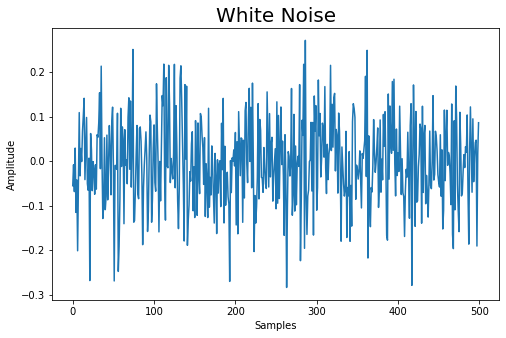

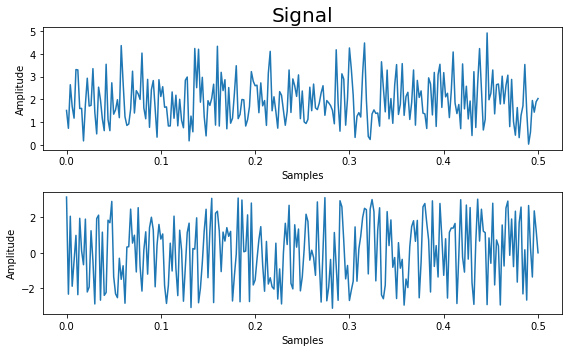

In [7]:
wn = laba1.WhiteNoise(deviation=0.1, size=500)
research(wn)

#### Прямое ДПФ Гармонического шума

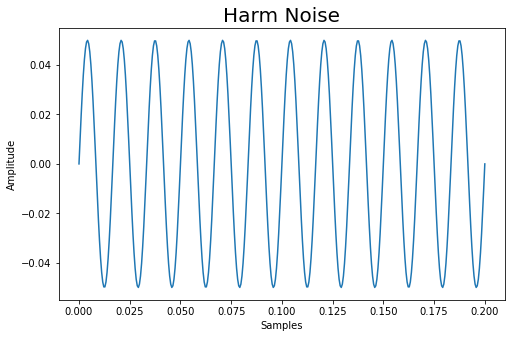

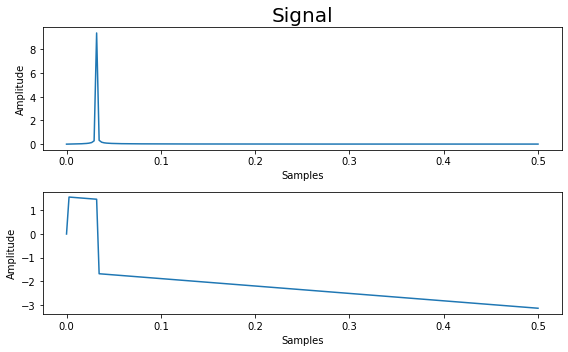

In [8]:
hn = laba1.HarmNoise(a_hn=0.05, f_d=5, f_hn=60, n_sin=1888)
research(hn)

### 5. Исследование пар преобразования Фурье 

- ### Дельта-функция

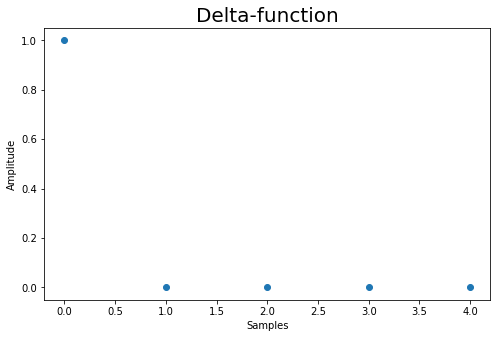

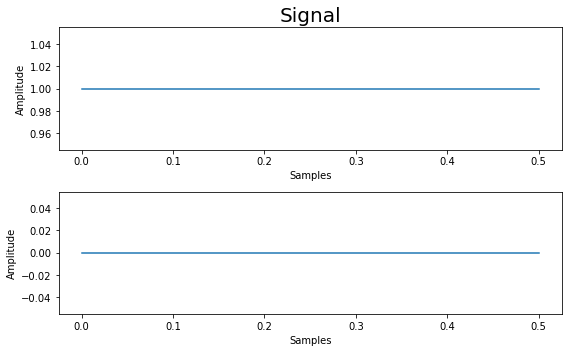

In [9]:
delta = laba1.Delta(0)
research(delta)

* ### Прямоугольный сигнал

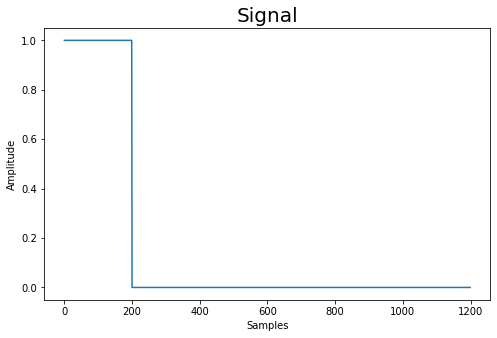

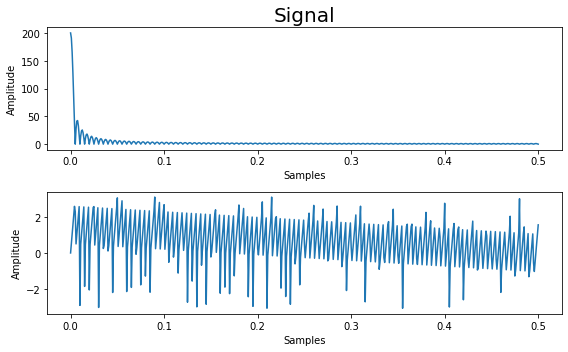

In [10]:
square = np.full(200, 1)
zero = np.zeros(1000)
square = Signal(np.append(square, zero))
research(square)

* ### Sinc-функция

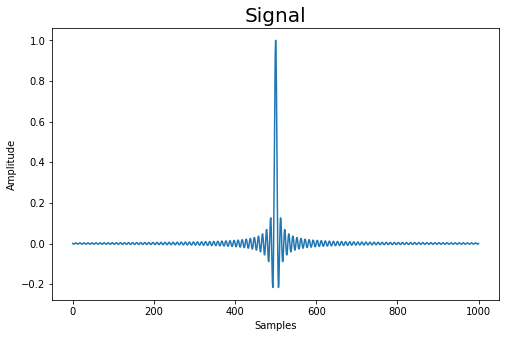

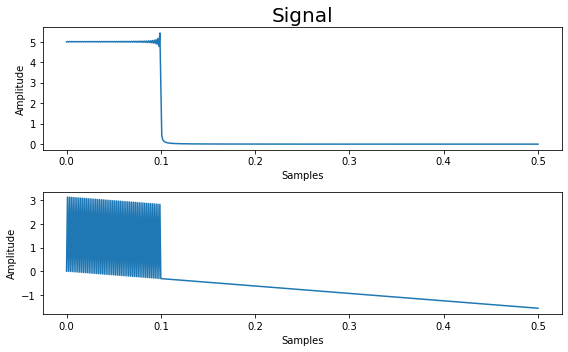

In [11]:
M = np.linspace(-100, 100, 1001)
sinc = np.sinc(M)
research(Signal(sinc))

* ### Треугольная-функция

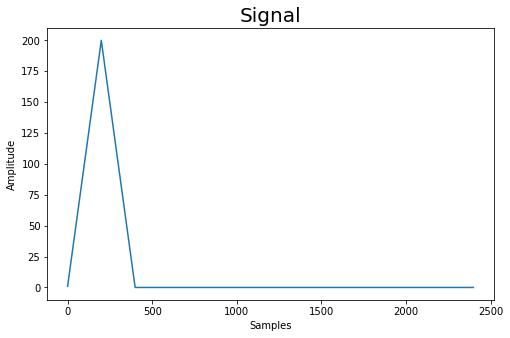

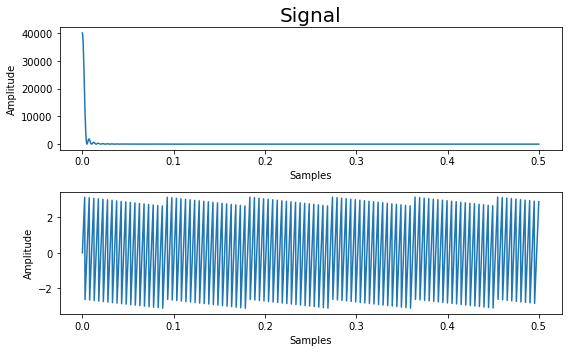

In [12]:
triangle = laba1.Convolution(square).signals_convolution(square)
research(triangle)

* ### Гаусова-функция

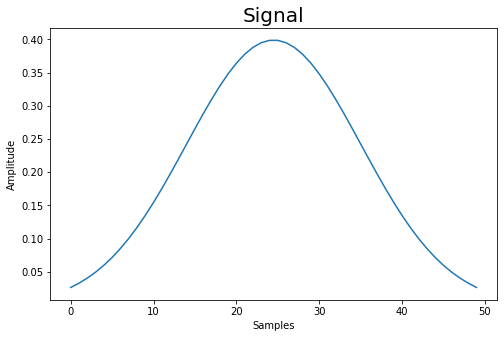

In [13]:
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 50)
gauss = Signal(norm.pdf(x))
gauss.print_()

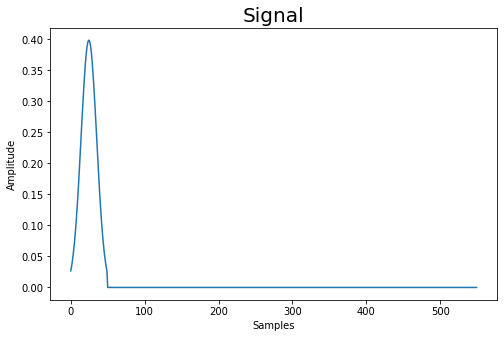

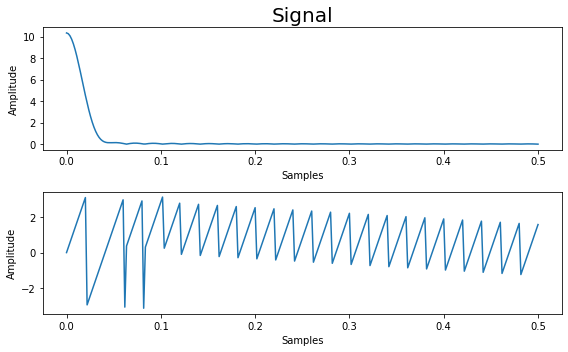

In [14]:
zero = np.zeros(500)
gauss = Signal(np.append(norm.pdf(x), zero))
research(gauss)

***
### Вывод: Изучили особенности реализации алгоритмов преобразования Фурье. Исследовали пары преобразования Фурье: delta-функция, прямоугольный сигнал, треугольный сигнал, Гаусова-функция.